Jupyter notebook used for doing exploratory data analysis and data prep on the raw Acxiom data created by the separate "Personal Data Datasets - camelot_pdf_reads.ipynb" notebook

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from lxml import etree
# from camelot import read_pdf
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
pd.set_option('display.max_colwidth', 250)

In [2]:
all_recs = pd.read_pickle('path to acxiom df created by camelot pdf extraction notebook') # loading df created when I used camelot to extract the data from the pdf

In [ ]:
all_recs

In [4]:
all_recs.reset_index(drop=True, inplace=True)

In [28]:
# find where the Data Collected/Processed section ends and the Data Sold section begins
all_recs.loc[all_recs[0].str.contains('Data Sold')] 

,0,1
2324,Data Sold - Data Category and Third Party Reci...,


In [5]:
end_idx = all_recs.index[all_recs[0].str.contains('Data Sold')].to_list()
end_idx

[2324]

In [6]:
all_recs.loc[1: end_idx[0]-1][0]

1        01. Personal Identifiers / 01. Name / Name (001)
2        01. Personal Identifiers / 01. Name / Name (002)
3        01. Personal Identifiers / 01. Name / Name (003)
4        01. Personal Identifiers / 01. Name / Name (004)
5        01. Personal Identifiers / 01. Name / Name (005)
                              ...                        
2319    11. Sensitive Information / 13. Ethnicity|Reli...
2320    11. Sensitive Information / 13. Ethnicity|Reli...
2321    11. Sensitive Information / 13. Ethnicity|Reli...
2322    11. Sensitive Information / 13. Ethnicity|Reli...
2323    11. Sensitive Information / 13. Ethnicity|Reli...
Name: 0, Length: 2323, dtype: object

In [7]:
# create lists of topics and sub-topics for the Data Collected/Processed records
all_recs['subject_list'] = all_recs.loc[1: end_idx[0]-1][0].str.split('/') 

In [8]:
all_recs['subject_list']

0                                                     NaN
1       [01. Personal Identifiers ,  01. Name ,  Name ...
2       [01. Personal Identifiers ,  01. Name ,  Name ...
3       [01. Personal Identifiers ,  01. Name ,  Name ...
4       [01. Personal Identifiers ,  01. Name ,  Name ...
                              ...                        
2351                                                  NaN
2352                                                  NaN
2353                                                  NaN
2354                                                  NaN
2355                                                  NaN
Name: subject_list, Length: 2356, dtype: object

In [33]:
# how many levels of topics and sub-topics are there in the Data Collected/Processed records?
all_recs.loc[1: end_idx[0]-1, 'subject_list'].apply(lambda x:len(x)).value_counts()

subject_list
3    2160
4     163
Name: count, dtype: int64

In [9]:
# create a separate df of Data Collected/Processed with topics and 
# sub-topics separated into columns
all_data_collected = pd.DataFrame(list(all_recs.loc[1: end_idx[0]-1, 'subject_list']))
all_data_collected

,0,1,2,3
0,01. Personal Identifiers,01. Name,Name (001),None
1,01. Personal Identifiers,01. Name,Name (002),None
2,01. Personal Identifiers,01. Name,Name (003),None
3,01. Personal Identifiers,01. Name,Name (004),None
4,01. Personal Identifiers,01. Name,Name (005),None
...,...,...,...,...
2318,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nHispanic Range,None
2319,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nSpanish Speaking Range (...,None
2320,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nSpanish Speaking Range (...,None
2321,11. Sensitive Information,13. Ethnicity|Religion,Race,None


In [10]:
all_data_collected.columns = ['top_level', 'top_plus_1', 'top_plus_2', 'top_plus_3']
all_data_collected = all_data_collected.fillna('')
all_data_collected

,top_level,top_plus_1,top_plus_2,top_plus_3
0,01. Personal Identifiers,01. Name,Name (001),
1,01. Personal Identifiers,01. Name,Name (002),
2,01. Personal Identifiers,01. Name,Name (003),
3,01. Personal Identifiers,01. Name,Name (004),
4,01. Personal Identifiers,01. Name,Name (005),
...,...,...,...,...
2318,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nHispanic Range,
2319,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nSpanish Speaking Range (...,
2320,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nSpanish Speaking Range (...,
2321,11. Sensitive Information,13. Ethnicity|Religion,Race,


In [36]:
# what are the main categories in the Data Collected/Processed group
all_data_collected.value_counts(subset=['top_level'])

top_level                                         
10. Inferences                                        1841
01. Personal Identifiers                               243
03. Personal Property or Buying Activity|Interest      174
02. Personal Characteristics                            36
11. Sensitive Information                               15
08. Employment Information                              11
09. Education Information                                2
05. Internet Activity                                    1
Name: count, dtype: int64

In [37]:
# counts for features that have at least 3 levels
all_data_collected.loc[~(all_data_collected['top_plus_2'] == '')].groupby(
    ['top_level', 'top_plus_1'])['top_plus_3'].count()

top_level                                           top_plus_1                                         
01. Personal Identifiers                             01. Name                                                13
                                                     02. Address                                             73
                                                     04. Phone|Fax                                           16
                                                     05. Email                                               17
                                                     09. Personal Identifiers                                 4
                                                     10. Other Identifiers                                  120
02. Personal Characteristics                         03. Date of Birth|Age|Gender                            10
                                                     11. Personal Attributes                                  3


In [38]:
# counts for features that have 4 levels
all_data_collected.loc[~(all_data_collected['top_plus_3'] == '')].groupby(
    ['top_level', 'top_plus_1'])['top_plus_3'].count()

top_level                                           top_plus_1                            
01. Personal Identifiers                             01. Name                                  1
                                                     02. Address                              44
                                                     04. Phone|Fax                             9
                                                     09. Personal Identifiers                  1
                                                     10. Other Identifiers                     4
02. Personal Characteristics                         17. Financial Information                 1
03. Personal Property or Buying Activity|Interest    20. Vehicle\nInformation                  4
                                                     22. Real Property                        29
                                                     76. Inferences-\nModels                  23
08. Employment Information          

In [40]:
# which columns contain multiple observations of the same data point
all_data_collected.loc[all_data_collected['top_plus_3'].str.contains(r'\(\d+\)')]

,top_level,top_plus_1,top_plus_2,top_plus_3
15,01. Personal Identifiers,02. Address,Address (001),Last Verified\nDate (001)
16,01. Personal Identifiers,02. Address,Address (001),Last Verified\nDate (002)
27,01. Personal Identifiers,02. Address,Address (004),Last Verified\nDate (001)
28,01. Personal Identifiers,02. Address,Address (004),Last Verified\nDate (002)
29,01. Personal Identifiers,02. Address,Address (004),Last Verified\nDate (003)
36,01. Personal Identifiers,02. Address,Address (007),\nLatitude|Longitude|Assignment Level (001)
37,01. Personal Identifiers,02. Address,Address (007),\nLatitude|Longitude|Assignment Level (002)
48,01. Personal Identifiers,02. Address,Address (014),Description\n(001)
49,01. Personal Identifiers,02. Address,Address (014),Description\n(002)
60,01. Personal Identifiers,02. Address,Address (019),\nLatitude|Longitude|Assignment Level (001)


In [41]:
# both the top_plus_2 and top_plus_3 levels contain multiple observations for the same
# apparent data feature
#
# check if top_level or top_plus_1 also contain multiple observations for the same
# data feature
all_data_collected.loc[all_data_collected['top_level'].str.contains(r'\(\d+\)')]

,top_level,top_plus_1,top_plus_2,top_plus_3


In [42]:
all_data_collected.loc[all_data_collected['top_plus_1'].str.contains(r'\(\d+\)')]

,top_level,top_plus_1,top_plus_2,top_plus_3


In [11]:
# only top_level_2 and top_level_3 contain multiple observations for the same feature

# create a version with multiple observations of the same data feature dropped,
# saving the apparent most recent observation
all_data_collected_no_dups = all_data_collected.sort_values(
    by=['top_level', 'top_plus_1', 'top_plus_2', 'top_plus_3'],
    ascending=[True, True, False, False])
all_data_collected_no_dups

,top_level,top_plus_1,top_plus_2,top_plus_3
12,01. Personal Identifiers,01. Name,Name (012),
11,01. Personal Identifiers,01. Name,Name (011),
10,01. Personal Identifiers,01. Name,Name (010),
9,01. Personal Identifiers,01. Name,Name (009),
8,01. Personal Identifiers,01. Name,Name (008),
...,...,...,...,...
2312,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nAsian Range (001),
2311,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nAfrican American Range,
2310,11. Sensitive Information,13. Ethnicity|Religion,Language Spoken,
2309,11. Sensitive Information,13. Ethnicity|Religion,Ethnicity Group,


In [12]:
# remove the occurence counter (e.g., (002)) from the multiple observation records
all_data_collected_no_dups = all_data_collected_no_dups.replace(r'\(\d+\)', '', regex=True)
all_data_collected_no_dups

,top_level,top_plus_1,top_plus_2,top_plus_3
12,01. Personal Identifiers,01. Name,Name,
11,01. Personal Identifiers,01. Name,Name,
10,01. Personal Identifiers,01. Name,Name,
9,01. Personal Identifiers,01. Name,Name,
8,01. Personal Identifiers,01. Name,Name,
...,...,...,...,...
2312,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nAsian Range,
2311,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nAfrican American Range,
2310,11. Sensitive Information,13. Ethnicity|Religion,Language Spoken,
2309,11. Sensitive Information,13. Ethnicity|Religion,Ethnicity Group,


In [45]:
all_data_collected_no_dups.duplicated(subset=['top_level', 'top_plus_1', 
                                              'top_plus_2', 'top_plus_3']).sum()

816

In [13]:
# 816 of 2,323 records, or 35%, are earlier observations of a data point
# drop the duplicates, keeping only the most currect observations of each data point
all_data_collected_no_dups.drop_duplicates(subset=['top_level', 'top_plus_1', 
                                              'top_plus_2', 'top_plus_3'], inplace=True)
all_data_collected_no_dups

,top_level,top_plus_1,top_plus_2,top_plus_3
12,01. Personal Identifiers,01. Name,Name,
7,01. Personal Identifiers,01. Name,Name,Description
85,01. Personal Identifiers,02. Address,Address,
79,01. Personal Identifiers,02. Address,Address,Year Built
78,01. Personal Identifiers,02. Address,Address,Home\nOwner|Renter
...,...,...,...,...
2313,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nAsian Range,
2311,11. Sensitive Information,13. Ethnicity|Religion,Percent Ethnicity -\nAfrican American Range,
2310,11. Sensitive Information,13. Ethnicity|Religion,Language Spoken,
2309,11. Sensitive Information,13. Ethnicity|Religion,Ethnicity Group,


In [14]:
all_data_collected_no_dups.value_counts(subset=['top_level'])

top_level                                         
10. Inferences                                        1287
03. Personal Property or Buying Activity|Interest      116
01. Personal Identifiers                                52
02. Personal Characteristics                            26
11. Sensitive Information                               12
08. Employment Information                              11
09. Education Information                                2
05. Internet Activity                                    1
Name: count, dtype: int64

In [48]:
all_data_collected_no_dups.loc[all_data_collected_no_dups['top_level'].str.contains('10. Inferences')].value_counts(
                                subset=['top_level', 'top_plus_1'])

top_level        top_plus_1                               
10. Inferences    76. Inferences-Models                       1164
                  79. Inferences-Buying Activity Behavior       62
                  78. Inferences-Financial Information          51
                  80. Inferences-Insurance                       7
                  77. Inferences-Email Information               2
                  57. Lifestyle Interest                         1
Name: count, dtype: int64

In [50]:
# see how many observations are about automobiles
all_data_collected_no_dups.loc[all_data_collected_no_dups['top_plus_2'].str.contains('Vehicle')]

,top_level,top_plus_1,top_plus_2,top_plus_3
301,03. Personal Property or Buying Activity|Inter...,20. Vehicle\nInformation,Vehicle Identifier - Year|Make|Model|VIN,
300,03. Personal Property or Buying Activity|Inter...,20. Vehicle\nInformation,Vehicle Identifier - Year|Make|Model|VIN,Fuel\nType
299,03. Personal Property or Buying Activity|Inter...,20. Vehicle\nInformation,Vehicle Identifier - Year|Make|Model|VIN,Class
294,03. Personal Property or Buying Activity|Inter...,20. Vehicle\nInformation,Average Number of Vehicles,
2040,10. Inferences,76. Inferences-Models,Vehicle RV Owner: Segment\n- Rank for Owning ...,
...,...,...,...,...
2258,10. Inferences,79. Inferences-Buying Activity Behavior,Vehicle\nLoyalty: Purchase Type - Lease Luxur...,
2257,10. Inferences,79. Inferences-Buying Activity Behavior,Vehicle\nLoyalty: Purchase Type - Lease Luxur...,
2256,10. Inferences,79. Inferences-Buying Activity Behavior,Vehicle\nLoyalty: Purchase Type - Lease Any S...,
2255,10. Inferences,79. Inferences-Buying Activity Behavior,Vehicle\nLoyalty: Purchase Type - Lease Any N...,


In [28]:
all_data_collected_no_dups.loc[all_data_collected_no_dups['top_plus_3'].str.contains('Vehicle')]

,top_level,top_plus_1,top_plus_2,top_plus_3


In [22]:
# how many inferences are NOT about autos
all_data_collected_no_dups.loc[~(all_data_collected_no_dups['top_plus_2'].str.contains('Vehicle')) &
                                (all_data_collected_no_dups['top_level'].str.contains('10. Inferences'))].value_counts(
                                subset=['top_level', 'top_plus_1'])


top_level        top_plus_1                               
10. Inferences    78. Inferences-Financial Information        49
                  76. Inferences-Models                       13
                  79. Inferences-Buying Activity Behavior     13
                  80. Inferences-Insurance                     7
                  77. Inferences-Email Information             2
                  57. Lifestyle Interest                       1
Name: count, dtype: int64

In [23]:
all_data_collected_no_dups.loc[(all_data_collected_no_dups['top_plus_1'].str.contains('76. Inferences-Models')) &
                                (all_data_collected_no_dups['top_level'].str.contains('10. Inferences'))].value_counts(
                                subset=['top_level', 'top_plus_1', 'top_plus_2'])

top_level        top_plus_1               top_plus_2                                                         
10. Inferences    76. Inferences-Models    Vehicle Loyalty: Segment -\nNon-Luxury 1                              6
                                           Vehicle Loyalty: Segment -\nNon-Luxury 3                              6
                                           Vehicle Loyalty: Segment -\nLuxury 1                                  3
                                           Vehicle Owner: Segment -\nRank for Owning - Non-Luxury Full-Size 3    2
                                           Vehicle Future In-Market:\nSegment - Non-Luxury 3                     2
                                                                                                                ..
                                           Vehicle In-Market: Vehicle\nFuel Type - New Electric (Any)            1
                                           Vehicle In-Market: Vehicle\nFuel Type - Ne

In [15]:
# LOTS of de-duped observations relate to vehicles
#
# now, let's do a topic analyses based on a re-constituted topic column,
# combining top_level through top_plus_3 into one column

all_data_collected_no_dups['new_topic'] = \
     all_data_collected_no_dups['top_level'].astype('str') + \
     all_data_collected_no_dups['top_plus_1'].astype('str') + \
     all_data_collected_no_dups['top_plus_2'].astype('str') + \
     all_data_collected_no_dups['top_plus_3'].astype('str')

all_data_collected_no_dups['new_topic']

12              01. Personal Identifiers  01. Name  Name 
7       01. Personal Identifiers  01. Name  Name   Des...
85        01. Personal Identifiers  02. Address  Address 
79      01. Personal Identifiers  02. Address  Address...
78      01. Personal Identifiers  02. Address  Address...
                              ...                        
2313    11. Sensitive Information  13. Ethnicity|Relig...
2311    11. Sensitive Information  13. Ethnicity|Relig...
2310    11. Sensitive Information  13. Ethnicity|Relig...
2309    11. Sensitive Information  13. Ethnicity|Relig...
2308    11. Sensitive Information  13. Ethnicity|Relig...
Name: new_topic, Length: 1507, dtype: object

In [16]:
# remove topic numbering, line break characters, and vertical bar characters
all_data_collected_no_dups['new_topic'] = \
    all_data_collected_no_dups['new_topic'].str.replace(r'\d+[.]', '', regex=True)
all_data_collected_no_dups['new_topic'] = \
    all_data_collected_no_dups['new_topic'].str.replace('\n', ' ')
all_data_collected_no_dups['new_topic'] = \
    all_data_collected_no_dups['new_topic'].str.replace('|', ' ')

In [3]:
all_data_collected_no_dups['new_topic']

12                     Personal Identifiers   Name  Name 
7         Personal Identifiers   Name  Name   Description
85               Personal Identifiers   Address  Address 
79       Personal Identifiers   Address  Address   Yea...
78       Personal Identifiers   Address  Address   Hom...
                              ...                        
2313     Sensitive Information   Ethnicity Religion  P...
2311     Sensitive Information   Ethnicity Religion  P...
2310     Sensitive Information   Ethnicity Religion  L...
2309     Sensitive Information   Ethnicity Religion  E...
2308     Sensitive Information   Ethnicity Religion  E...
Name: new_topic, Length: 1507, dtype: object

In [21]:
# backup the data
all_data_collected_no_dups.to_pickle('Acxiom/all_data_collected_no_dups.pkl')

In [2]:
all_data_collected_no_dups = pd.read_pickle('Acxiom/all_data_collected_no_dups.pkl')

In [54]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeffb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
from nltk.corpus import stopwords

In [56]:
stopwords_list = stopwords.words('english')

In [58]:
from sklearn.feature_extraction.text import CountVectorizer 

In [ ]:
# doing topic analysis as described in https://www.anaconda.com/blog/introduction-to-text-analysis-with-python-in-excel
# some preprocessing steps modelled after https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8

In [ ]:
# do topic analysis only on the Inferences records that relate to vehicles

In [59]:
veh_inf_no_dups_veh = \
    all_data_collected_no_dups.loc[(all_data_collected_no_dups['new_topic'].str.startswith(' Inferences')) &
                                   (all_data_collected_no_dups['new_topic'].str.contains('Vehicle')),
                                   'new_topic']

In [60]:
print(veh_inf_no_dups_veh.head(), '\n\n', 
      veh_inf_no_dups_veh.tail(), '\n\n', 'length:', len(veh_inf_no_dups_veh)) 

2040     Inferences   Inferences-Models  Vehicle RV Ow...
2039     Inferences   Inferences-Models  Vehicle RV Ow...
2038     Inferences   Inferences-Models  Vehicle RV Ow...
2037     Inferences   Inferences-Models  Vehicle Owner...
2036     Inferences   Inferences-Models  Vehicle Owner...
Name: new_topic, dtype: object 

 2258     Inferences   Inferences-Buying Activity Behav...
2257     Inferences   Inferences-Buying Activity Behav...
2256     Inferences   Inferences-Buying Activity Behav...
2255     Inferences   Inferences-Buying Activity Behav...
2254     Inferences   Inferences-Buying Activity Behav...
Name: new_topic, dtype: object 

 length: 1202


In [61]:
# drop 'Inferences' and 'Inferences-' from the text 
# as they do not add anything to the topic analysis
veh_inf_no_dups_veh = veh_inf_no_dups_veh.str.replace('Inferences-', ' ')
veh_inf_no_dups_veh = veh_inf_no_dups_veh.str.replace('Inferences', ' ')
veh_inf_no_dups_veh

2040          Models  Vehicle RV Owner: Segment - Rank...
2039          Models  Vehicle RV Owner: Segment - Rank...
2038          Models  Vehicle RV Owner: Segment - Rank...
2037          Models  Vehicle Owner: Segment - Rank fo...
2036          Models  Vehicle Owner: Segment - Rank fo...
                              ...                        
2258          Buying Activity Behavior  Vehicle Loyalt...
2257          Buying Activity Behavior  Vehicle Loyalt...
2256          Buying Activity Behavior  Vehicle Loyalt...
2255          Buying Activity Behavior  Vehicle Loyalt...
2254          Buying Activity Behavior  Vehicle Loyalt...
Name: new_topic, Length: 1202, dtype: object

In [62]:
ngram_range = (3,5)
color_spec='c'
if ngram_range[0] == 2:
    ngram_txt_1 = 'Bi-grams'
elif ngram_range[0] == 3:
    ngram_txt_1 = 'Tri-grams'
else:
    ngram_txt_1 = f'{ngram_range[0]}-grams'

if ngram_range[1] == 3:
    ngram_txt_2 = 'Tri-grams'
else:
    ngram_txt_2 = f'{ngram_range[1]}-grams'
    
plot_title_text = 'Inferences - Collected/Processed Data\n' + \
                  'Vehicle-related Features\n' + \
                   ngram_txt_1 + ' - ' + ngram_txt_2
print(plot_title_text)

Inferences - Collected/Processed Data
Vehicle-related Features
Tri-grams - 5-grams


In [63]:
type(veh_inf_no_dups_veh)

pandas.core.series.Series

In [64]:
veh_inf_no_dups_veh.info(show_counts=True)

<class 'pandas.core.series.Series'>
Index: 1202 entries, 2040 to 2254
Series name: new_topic
Non-Null Count  Dtype 
--------------  ----- 
1202 non-null   object
dtypes: object(1)
memory usage: 18.8+ KB


In [53]:
# Create CountVectorizer object
# CountVectorizer converts a collection of text documents to a matrix of token counts
c_vec = CountVectorizer(stop_words=stopwords_list, ngram_range=ngram_range)
# Fit the CountVectorizer to the reviews data to get a matrix of ngrams
ngrams = c_vec.fit_transform(veh_inf_no_dups_veh)

In [54]:
ngrams

<1202x4780 sparse matrix of type '<class 'numpy.int64'>'
	with 16721 stored elements in Compressed Sparse Row format>

In [55]:
# Count the frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

In [56]:
# Get a list of ngrams
vocab = c_vec.vocabulary_

In [57]:
vocab

{'models vehicle rv': 1648,
 'vehicle rv owner': 4756,
 'rv owner segment': 3692,
 'owner segment rank': 2532,
 'segment rank owning': 3822,
 'rank owning rv': 3575,
 'models vehicle rv owner': 1649,
 'vehicle rv owner segment': 4757,
 'rv owner segment rank': 3693,
 'owner segment rank owning': 2533,
 'segment rank owning rv': 3836,
 'models vehicle rv owner segment': 1650,
 'vehicle rv owner segment rank': 4758,
 'rv owner segment rank owning': 3694,
 'owner segment rank owning rv': 2537,
 'rank owning non': 3540,
 'owning non motorized': 2936,
 'non motorized rv': 2075,
 'segment rank owning non': 3833,
 'rank owning non motorized': 3550,
 'owning non motorized rv': 2937,
 'owner segment rank owning non': 2536,
 'segment rank owning non motorized': 3835,
 'rank owning non motorized rv': 3551,
 'rank owning motorized': 3519,
 'owning motorized rv': 2893,
 'segment rank owning motorized': 3831,
 'rank owning motorized rv': 3520,
 'owner segment rank owning motorized': 2535,
 'segment 

In [58]:
# Create a DataFrame to store the frequency and n-gram, sorted in descending order of frequency
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:ngram_txt_1 + ' - ' + ngram_txt_2})
# Display the top 10 n-grams by frequency
df_ngram.head(n=10) 

,frequency,Tri-grams - 5-grams
0,499,models vehicle owner
1,382,vehicle owner rank owning
2,382,vehicle owner rank
3,382,owner rank owning
4,382,models vehicle owner rank owning
5,382,models vehicle owner rank
6,355,models vehicle market
7,262,models vehicle loyalty
8,256,vehicle market new
9,256,models vehicle market new


In [59]:
df_ngram.head(50)

,frequency,Tri-grams - 5-grams
0,499,models vehicle owner
1,382,vehicle owner rank owning
2,382,vehicle owner rank
3,382,owner rank owning
4,382,models vehicle owner rank owning
5,382,models vehicle owner rank
6,355,models vehicle market
7,262,models vehicle loyalty
8,256,vehicle market new
9,256,models vehicle market new


C:\Users\jeffb\AppData\Local\Temp\ipykernel_32480\2454415023.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, rotation=0)


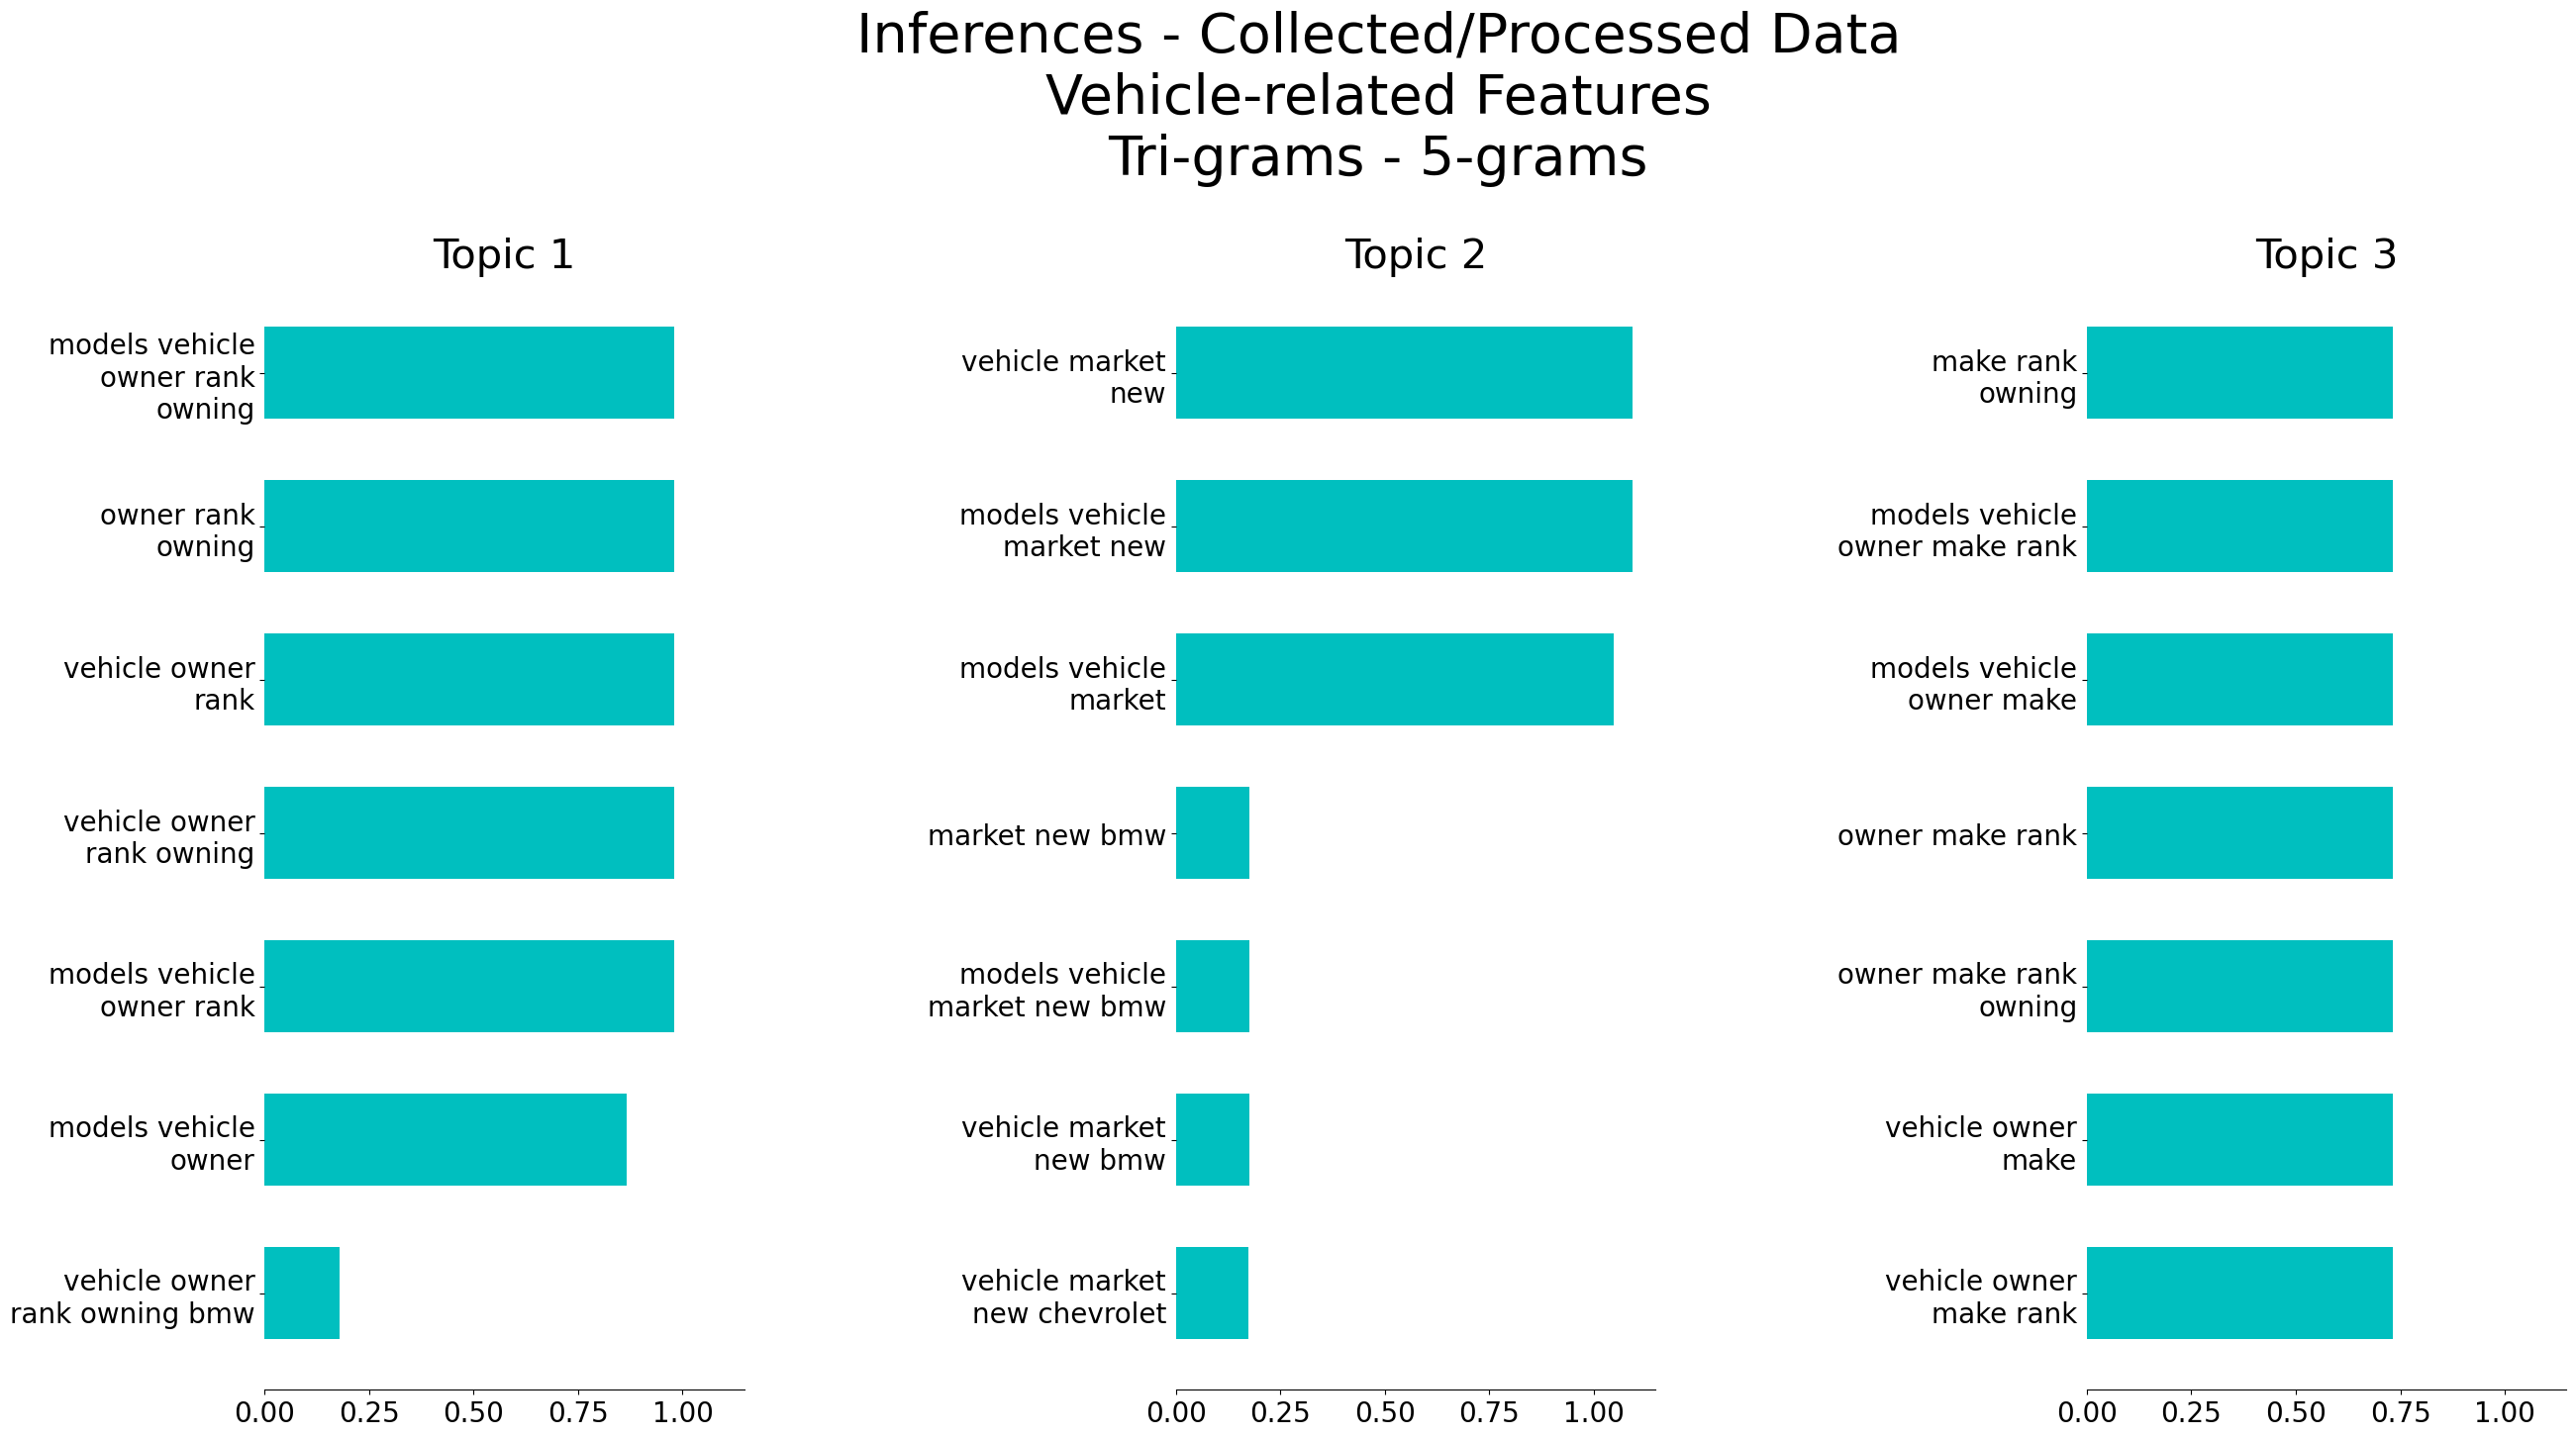

In [63]:
# plot top words

# Create a TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=ngram_range)

# Create an NMF (Non-Negative Matrix Factorization) object
# The n_components parameter is used to specify the number of topics to extract
nmf = NMF(n_components=3)

# Create a pipeline object that sequentially applies the TF-IDF vectorizer and NMF
pipe = make_pipeline(tfidf_vectorizer, nmf)

# Fit the pipeline to the reviews data
pipe.fit(veh_inf_no_dups_veh)

import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

def plot_top_words(model, feature_names, n_top_words, title):
    """
    Plot top words in topics 
    source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """

    # text wrapping pattern from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.6, color=color_spec)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        wrap_labels(ax, 15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.8, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Plot the top words in the topics identified by the NMF model
plot_top_words(
    nmf, tfidf_vectorizer.get_feature_names_out(), 7, plot_title_text
)

In [ ]:
# do topic analysis only on the Inferences records that do not relate to vehicles

In [103]:
veh_inf_no_dups_no_veh = \
    all_data_collected_no_dups.loc[(all_data_collected_no_dups['new_topic'].str.startswith(' Inferences')) &
                                   ~(all_data_collected_no_dups['new_topic'].str.contains('Vehicle')),
                                   'new_topic']

In [104]:
print(veh_inf_no_dups_no_veh.head(), '\n\n', 
      veh_inf_no_dups_no_veh.tail(), '\n\n', 'length:', len(veh_inf_no_dups_no_veh)) 

469     Inferences   Lifestyle Interest  Affinity Ran...
489         Inferences   Inferences-Models  Stress Level
488     Inferences   Inferences-Models  Social Settin...
487     Inferences   Inferences-Models  Smoking Frequ...
486        Inferences   Inferences-Models  Sleep Quality
Name: new_topic, dtype: object 

 2305     Inferences   Inferences-Insurance  Insurance ...
2304     Inferences   Inferences-Insurance  Insurance ...
2303     Inferences   Inferences-Insurance  Insurance ...
2302     Inferences   Inferences-Insurance  Insurance ...
2301     Inferences   Inferences-Insurance  Insurance ...
Name: new_topic, dtype: object 

 length: 85


In [105]:
# drop 'Inferences' and 'Inferences-' from the text 
# as they do not add anything to the topic analysis
veh_inf_no_dups_no_veh = veh_inf_no_dups_no_veh.str.replace('Inferences-', ' ')
veh_inf_no_dups_no_veh = veh_inf_no_dups_no_veh.str.replace('Inferences', ' ')
veh_inf_no_dups_no_veh

469          Lifestyle Interest  Affinity Rank - Inter...
489                                  Models  Stress Level
488                       Models  Social Setting Behavior
487                             Models  Smoking Frequency
486                                 Models  Sleep Quality
                              ...                        
2305          Insurance  Insurance - Likely to Respond...
2304          Insurance  Insurance - Likely to Respond...
2303          Insurance  Insurance - Likely to Respond...
2302          Insurance  Insurance - Likely to Respond...
2301          Insurance  Insurance - High Lifetime Val...
Name: new_topic, Length: 85, dtype: object

In [186]:
ngram_range = (2,4)
color_spec='b'
if ngram_range[0] == 2:
    ngram_txt_1 = 'Bi-grams'
elif ngram_range[0] == 3:
    ngram_txt_1 = 'Tri-grams'
else:
    ngram_txt_1 = f'{ngram_range[0]}-grams'

if ngram_range[1] == 3:
    ngram_txt_2 = 'Tri-grams'
else:
    ngram_txt_2 = f'{ngram_range[1]}-grams'
    
plot_title_text = 'Inferences - Collected/Processed Data\n' + \
                  'Non-vehicle-related Features\n' + \
                   ngram_txt_1 + ' - ' + ngram_txt_2
print(plot_title_text)

Inferences - Collected/Processed Data
Non-vehicle-related Features
Bi-grams - 4-grams


In [187]:
# Create CountVectorizer object
# CountVectorizer converts a collection of text documents to a matrix of token counts
c_vec = CountVectorizer(stop_words=stopwords_list, ngram_range=ngram_range)
# Fit the CountVectorizer to the reviews data to get a matrix of ngrams
ngrams = c_vec.fit_transform(veh_inf_no_dups_no_veh)

In [188]:
ngrams

<85x556 sparse matrix of type '<class 'numpy.int64'>'
	with 1073 stored elements in Compressed Sparse Row format>

In [189]:
# Count the frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

In [190]:
# Get a list of ngrams
vocab = c_vec.vocabulary_

In [191]:
vocab

{'lifestyle interest': 359,
 'interest affinity': 346,
 'affinity rank': 11,
 'rank internet': 471,
 'internet buyer': 350,
 'lifestyle interest affinity': 360,
 'interest affinity rank': 347,
 'affinity rank internet': 12,
 'rank internet buyer': 472,
 'lifestyle interest affinity rank': 361,
 'interest affinity rank internet': 348,
 'affinity rank internet buyer': 13,
 'models stress': 435,
 'stress level': 538,
 'models stress level': 436,
 'models social': 432,
 'social setting': 513,
 'setting behavior': 508,
 'models social setting': 433,
 'social setting behavior': 514,
 'models social setting behavior': 434,
 'models smoking': 430,
 'smoking frequency': 510,
 'models smoking frequency': 431,
 'models sleep': 428,
 'sleep quality': 509,
 'models sleep quality': 429,
 'models safety': 426,
 'safety compliance': 500,
 'models safety compliance': 427,
 'models overall': 424,
 'overall wellness': 451,
 'models overall wellness': 425,
 'models healthy': 422,
 'healthy lifestyle': 187

In [192]:
# Create a DataFrame to store the frequency and n-gram, sorted in descending order of frequency
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:ngram_txt_1 + ' - ' + ngram_txt_2})
# Display the top 10 n-grams by frequency
df_ngram.head(n=10) 

,frequency,Bi-grams - 4-grams
0,49,financial information
1,14,likely respond
2,14,household regulation
3,13,buying activity behavior household
4,13,buying activity behavior
5,13,buying activity
6,13,behavior household
7,13,activity behavior household
8,13,activity behavior
9,12,household dollars spent


In [194]:
df_ngram.head(50)

,frequency,Bi-grams - 4-grams
0,49,financial information
1,14,likely respond
2,14,household regulation
3,13,buying activity behavior household
4,13,buying activity behavior
5,13,buying activity
6,13,behavior household
7,13,activity behavior household
8,13,activity behavior
9,12,household dollars spent


C:\Users\jeffb\AppData\Local\Temp\ipykernel_8128\83677914.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, rotation=0)


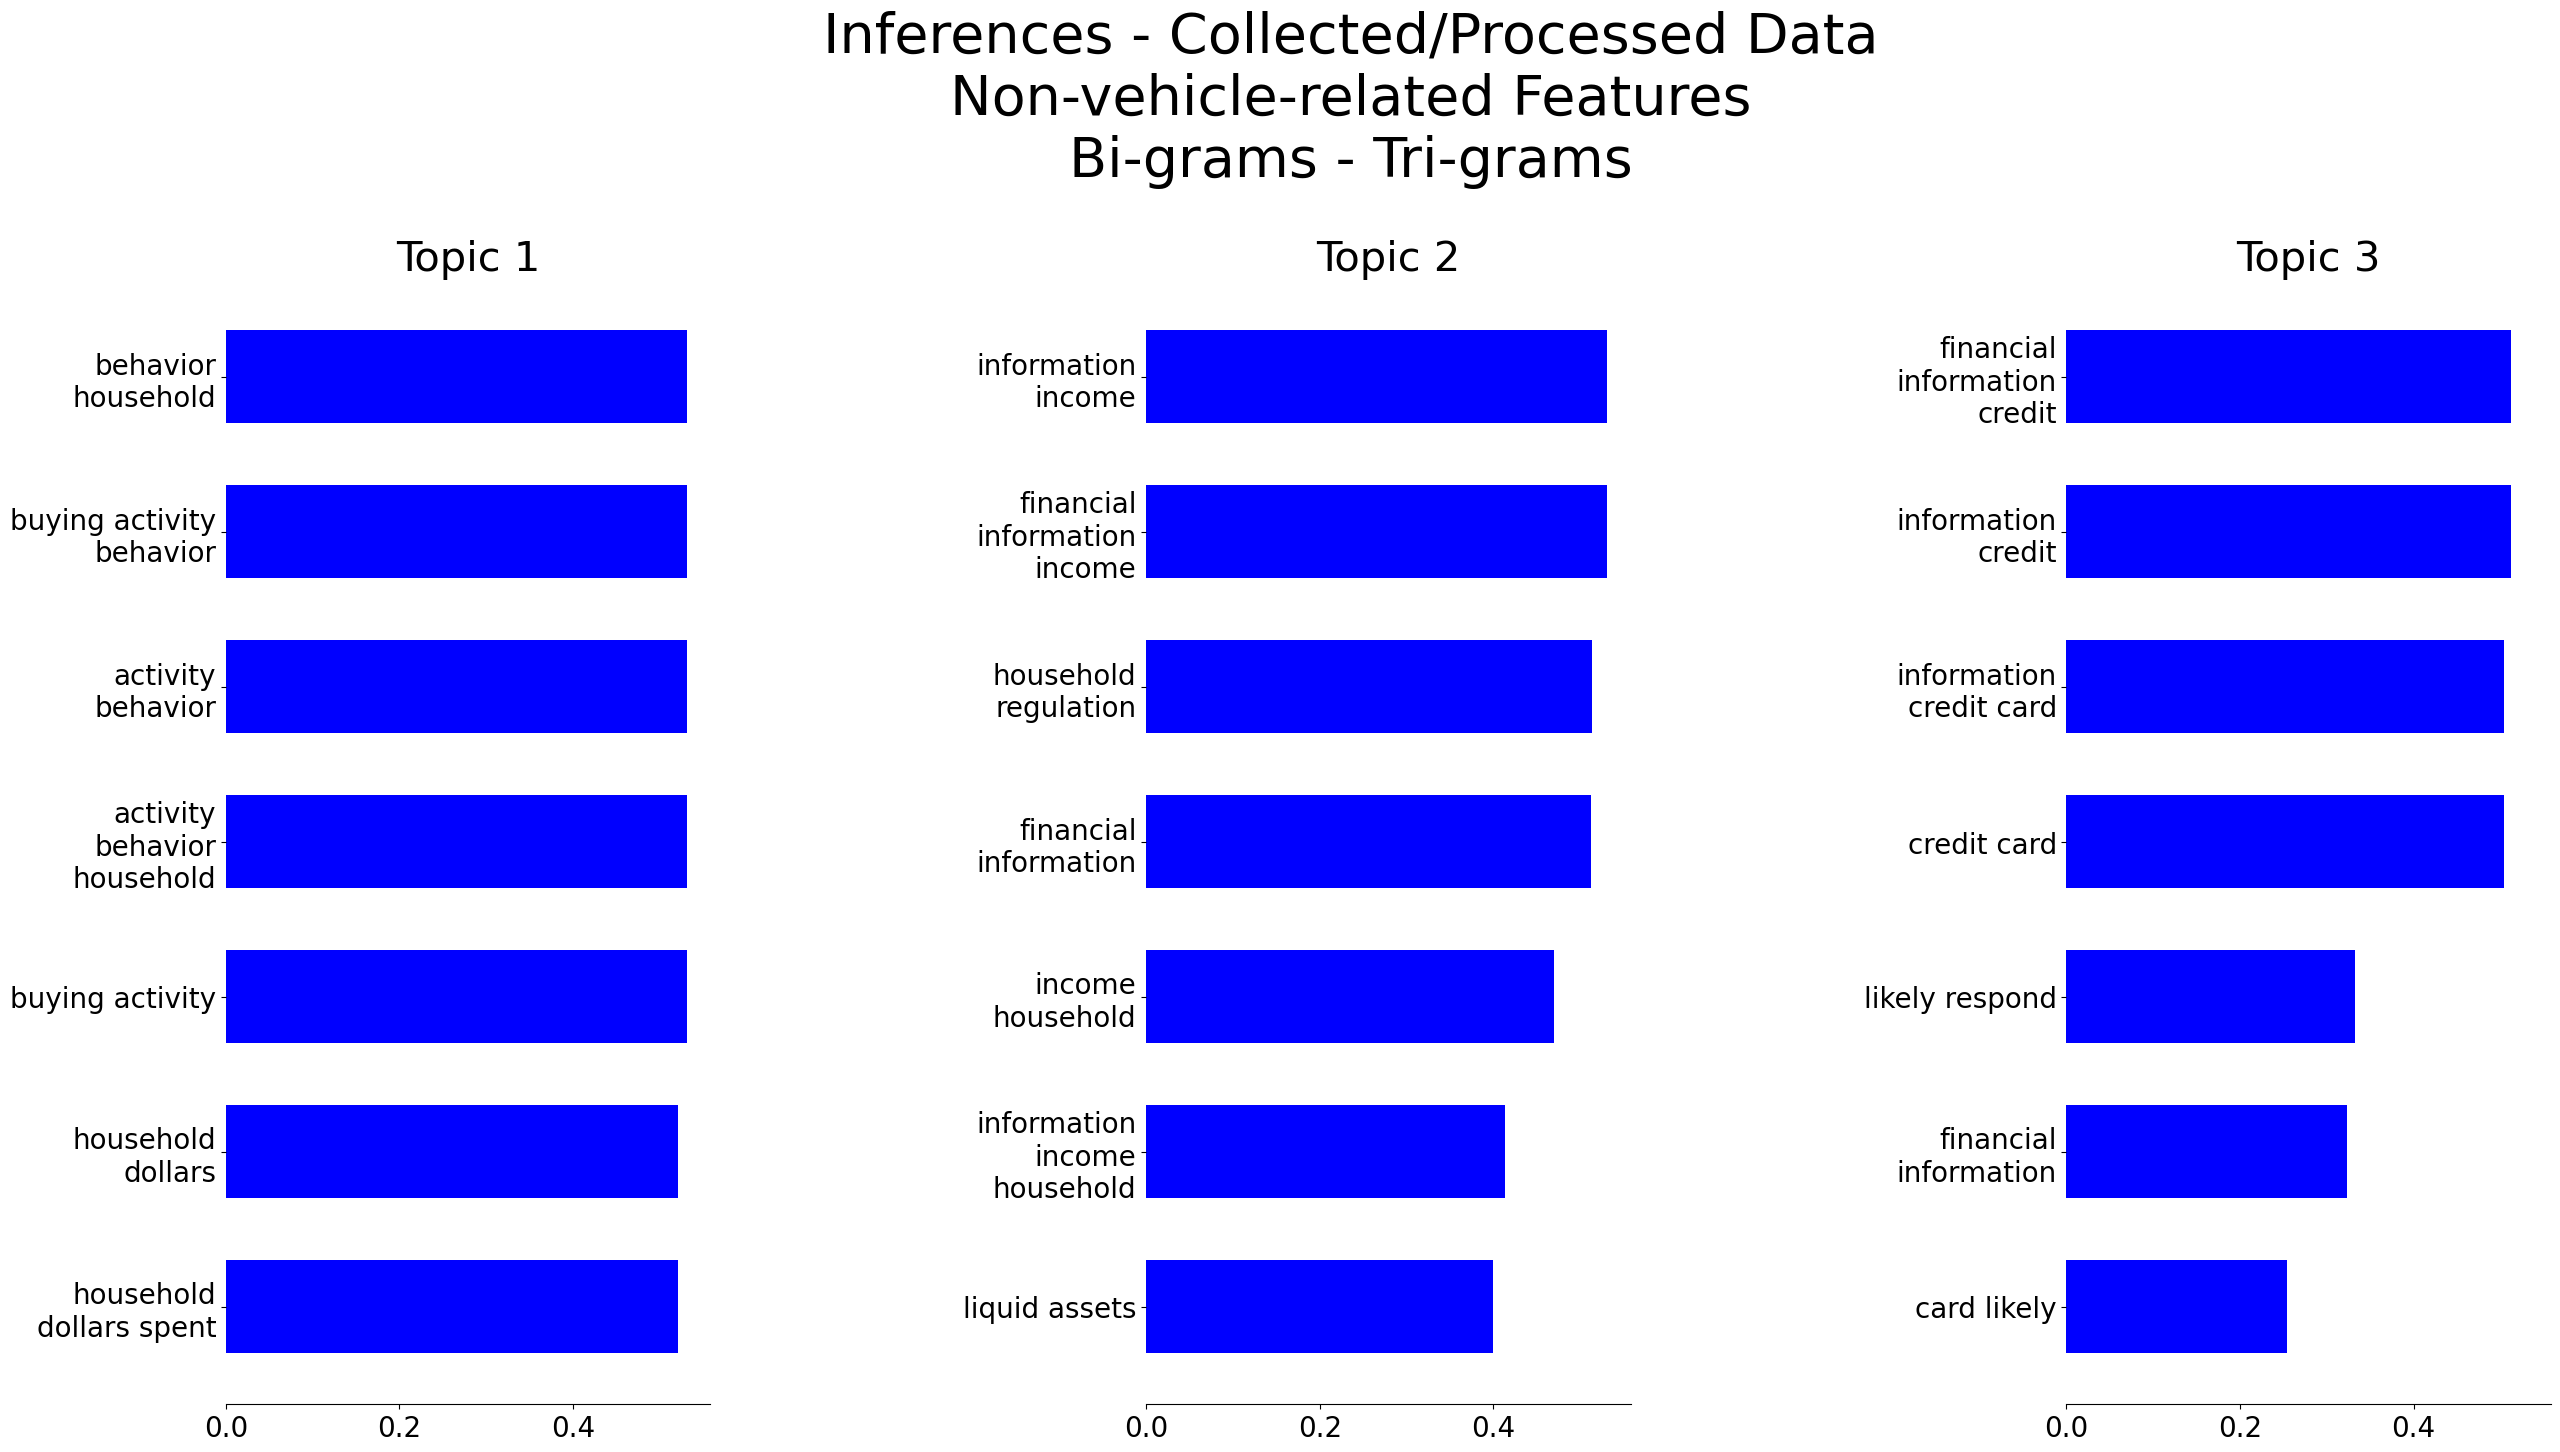

In [185]:
# plot top words

# Create a TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=ngram_range)

# Create an NMF (Non-Negative Matrix Factorization) object
# The n_components parameter is used to specify the number of topics to extract
nmf = NMF(n_components=3)

# Create a pipeline object that sequentially applies the TF-IDF vectorizer and NMF
pipe = make_pipeline(tfidf_vectorizer, nmf)

# Fit the pipeline to the reviews data
pipe.fit(veh_inf_no_dups_no_veh)

import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

def plot_top_words(model, feature_names, n_top_words, title):
    """
    Plot top words in topics 
    source: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """

    # text wrapping pattern from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.6, color=color_spec)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        wrap_labels(ax, 15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.8, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Plot the top words in the topics identified by the NMF model
plot_top_words(
    nmf, tfidf_vectorizer.get_feature_names_out(), 7, plot_title_text
)